# October 9, 2020

The purpose of this notebook is to organize my code.

In [1]:
import neural_dimensionality_reduction as ndr
import numpy as np

Train a model.

In [2]:
spikes, _ = ndr.data.get_spikes_data(ndr.data.data_dir, tetrode_id=6)
print(spikes.shape)

mu, sigma = 1000, 2
som = ndr.reduction.SelfOrganizingMap3D((16, 16, 16, 4), mu, sigma)

for i in range(spikes.shape[0]):
    som.train1(spikes[i])

/nix/store/kpc7kmgvz2nb6ccyhbdlp0gxknb7l2kf-python3-3.8.5-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (11,12,13,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(44064, 4)


Transform spikes.

In [3]:
multiunits, position = ndr.data.get_formatted_data(ndr.data.data_dir, tetrode_id=6)
multiunits_transformed = ndr.data.transform_formatted_data(som, multiunits)
print(position.shape)
print(multiunits.shape)
print(multiunits_transformed.shape)

(615851,)
(615851, 4, 1)
(615851, 3, 1)


In [4]:
from replay_trajectory_classification import ClusterlessDecoder

In [5]:
model_kwargs = {
    'bandwidth': np.array([1.0, 1.0, 1.0, 1.0, 12.5]) # 1, 2, 3, 4, position
}
decoder_raw = ClusterlessDecoder(model_kwargs=model_kwargs)  

decoder_raw.fit(position, multiunits)

/home/trevortknguyen/repos/dimensionality/replay_trajectory_classification/state_transition.py:10: RuntimeWarning: invalid value encountered in true_divide
  x /= x.sum(axis=1, keepdims=True)


ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([ 1. ,  1. ,  1. ,  1. , 12.5])},
                   movement_var=0.05,
                   occupancy_kwargs={'bandwidth': array([ 1. ,  1. ,  1. ,  1. , 12.5])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=2.0, position_range=None, replay_speed=40,
                   transition_type='random_walk')

In [6]:
model_kwargs = {
    'bandwidth': np.array([1.0, 1.0, 1.0, 12.5]) # 1, 2, 3, 4, position
}
decoder_som = ClusterlessDecoder(model_kwargs=model_kwargs)  

decoder_som.fit(position, multiunits_transformed)

ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([ 1. ,  1. ,  1. , 12.5])},
                   movement_var=0.05,
                   occupancy_kwargs={'bandwidth': array([ 1. ,  1. ,  1. , 12.5])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=2.0, position_range=None, replay_speed=40,
                   transition_type='random_walk')

Evaluating

In [135]:
spikes_idx = np.argwhere(np.logical_not(np.isnan(multiunits)).any(axis=1)[:,0])[:,0]

In [136]:
predict_raw = decoder_raw.predict(multiunits[spikes_idx[:500]], is_compute_acausal=False)

In [137]:
predict_som = decoder_som.predict(multiunits_transformed[spikes_idx[:500]], is_compute_acausal=False)

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

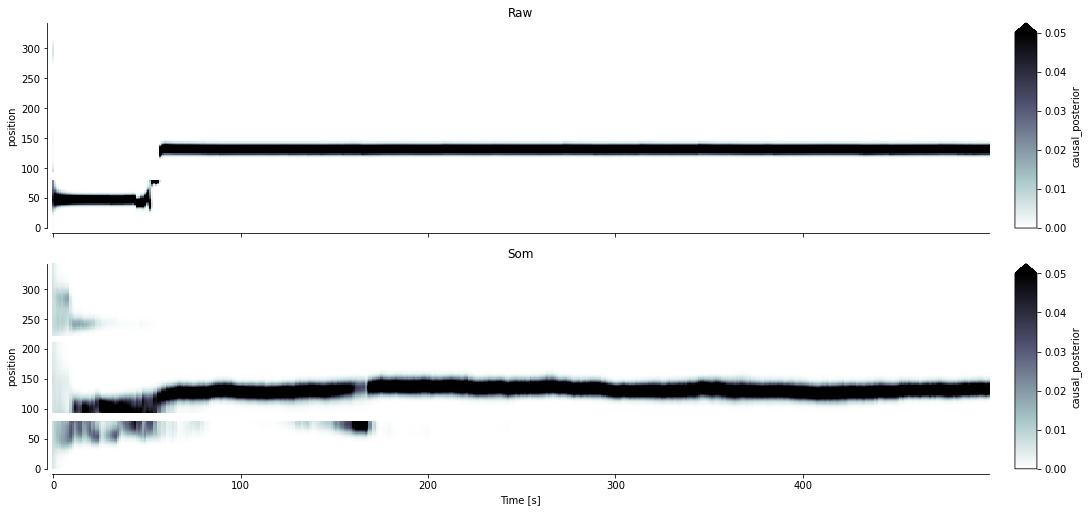

In [139]:
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(15, 7))

predict_raw.causal_posterior.plot(x="time", y="position", ax=axes[0], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[0].set_xlabel("")
axes[0].set_title("Raw")
predict_som.causal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[1].set_title("Som")
axes[1].set_xlabel('Time [s]')
sns.despine(offset=5)

In [140]:
pred_raw = np.argmax(np.nan_to_num(predict_raw.causal_posterior), axis=1)

In [141]:
pred_som = np.argmax(np.nan_to_num(predict_som.causal_posterior), axis=1)

In [142]:
np.mean(np.square(pred_raw - pred_som))

96.642

1000,500 - 205.9

1000,2 - 96.642

0,2 - 71.79

Now I should probably use all of the tetrodes now.